In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
import netCDF4 as nc

# E3SM-1-1 analysis

In [10]:
dpr='/global/cfs/cdirs/m3920/dataset/cmip6/E3SM-1-1/'
ds=xr.open_dataset(dpr+'/msftmz_Omon_E3SM-1-1_historical_r1i1p1f1_gr_185001-201412.nc')
df=xr.open_dataset(dpr+'/fgco2_Oyr_E3SM-1-1_historical_r1i1p1f1_gwoa13cpsurf_1850-2014.nc')

/global/homes/t/takaito/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


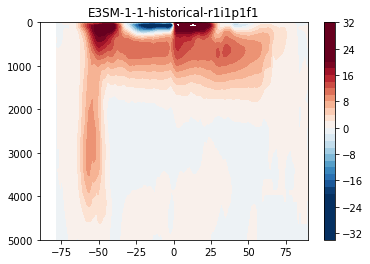

In [11]:
moc0=ds.msftmz
moc1=moc0.mean(dim='time').to_numpy()*1e-6/1025
x=ds.lat.to_numpy()
y=ds.lev.to_numpy()
moc=np.squeeze(moc1[0,:,:])
c=np.arange(-34,34,2)
plt.contourf(x,y,moc,c,cmap='RdBu_r',vmin=-20,vmax=20)
plt.ylim(5000,0)
plt.title('E3SM-1-1-historical-r1i1p1f1')
plt.colorbar()
wn='fig_amoc_e3sm'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

In [12]:
moc2=moc0.sel(lat=26,method='nearest').to_numpy()*1e-6/1025
moc3=np.squeeze(moc2[:,1,:])

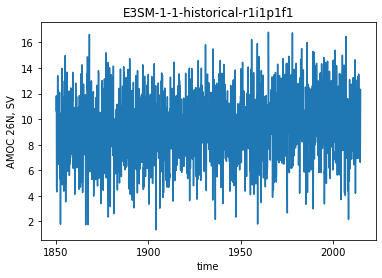

In [13]:
amoc26N=np.max(moc3,axis=1)
np.shape(amoc26N)
plt.plot(ds.time,amoc26N)
plt.xlabel('time')
plt.ylabel('AMOC 26N, SV')
plt.title('E3SM-1-1-historical-r1i1p1f1')
plt.show()

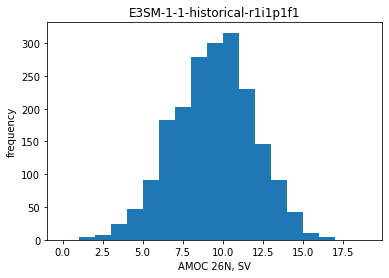

In [14]:
b=np.arange(0,20,1)
plt.hist(amoc26N,b)
plt.ylabel('frequency')
plt.xlabel('AMOC 26N, SV')
plt.title('E3SM-1-1-historical-r1i1p1f1')
plt.show()

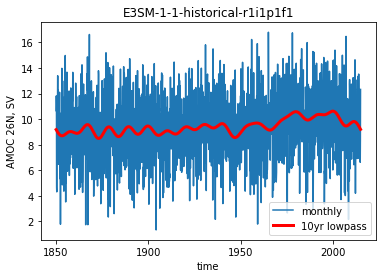

In [15]:
# fft filter
c=np.fft.fft(amoc26N)
freq=np.fft.fftfreq(np.size(amoc26N))
ind=(np.abs(freq)>1/120)
c[ind]=0
amoc_lp=np.fft.ifft(c)
plt.plot(ds.time,amoc26N,label='monthly')
plt.plot(ds.time,np.real(amoc_lp),'r-',label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.ylabel('AMOC 26N, SV')
plt.title('E3SM-1-1-historical-r1i1p1f1')
wn='fig_amocts_e3sm'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.legend()
plt.show()

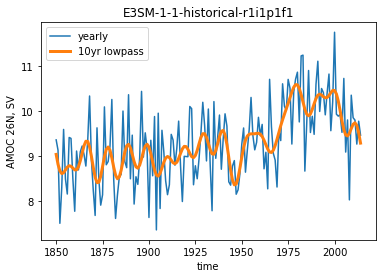

In [16]:
# annual mean
moc4=moc0.sel(lat=26,method='nearest')
moc5=moc4.groupby('time.year').mean(dim='time')
moc6=np.squeeze(moc5[:,1,:])
amoc26Na=np.max(moc6,axis=1).to_numpy()*1e-6/1025
year=moc5.year
# fft filter
c=np.fft.fft(amoc26Na)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/10)
c[ind]=0
amoc_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,amoc26Na,label='yearly')
plt.plot(np.linspace(1850,2014,165),amoc_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.ylabel('AMOC 26N, SV')
plt.title('E3SM-1-1-historical-r1i1p1f1')
wn='fig_amocts_e3sm'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()


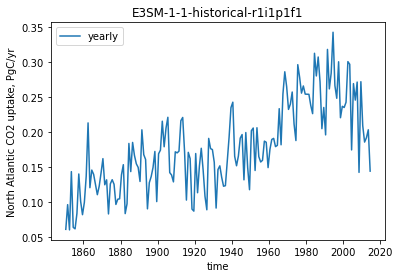

In [17]:
R=6.37e6
dx=1
cfac=365.25*86400*1.e-3
# calculate global uptake
weights=np.cos(np.deg2rad(df.lat))*(R*np.pi/180*dx)**2
weights.name = "weights"
#fgco2=df.fgco2.where((df.lon>=300)&(df.lat>10))
fgco2=df.fgco2.where((df.lat>=10)&((df.lon>(360-85))|(df.lon<10)))
fgco2_weighted=fgco2.weighted(weights)
co2uptake=cfac*fgco2_weighted.sum(('lon','lat'))*12e-15
#
# fft filter
y=co2uptake.to_numpy()
c=np.fft.fft(y[:,0])
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/20)
c[ind]=0
co2uptake_lp=np.real(np.fft.ifft(c))
#
plt.plot(df.time,co2uptake,label='yearly')
#plt.plot(df.time,co2uptake_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.title('E3SM-1-1-historical-r1i1p1f1')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
wn='fig_NAfgco2ts_lowpass_e3sm'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

ratio(yearly)= 0.03732132568251685
ratio(low pass)= 0.07252863908359779


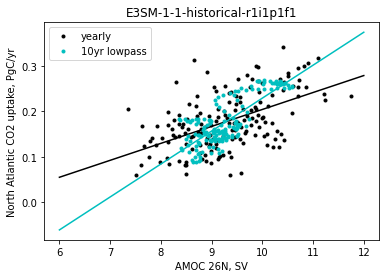

In [18]:
#x=amoc_lp
x=amoc26Na
#y=co2uptake_lp
y=co2uptake.to_numpy()[:,0]
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
x0=np.linspace(6,12,20)
#
plt.plot(x,y,'k.',label='yearly')
plt.plot(x0,a*x0+b,'k-')
print('ratio(yearly)=',a)
#
x=np.real(amoc_lp)
y=np.real(co2uptake_lp)
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
plt.plot(amoc_lp,co2uptake_lp,'c.',label='10yr lowpass')
plt.plot(x0,a*x0+b,'c-')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
plt.legend()
plt.xlabel('AMOC 26N, SV')
plt.title('E3SM-1-1-historical-r1i1p1f1')
print('ratio(low pass)=',a)
wn='fig_amocco2_e3sm'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

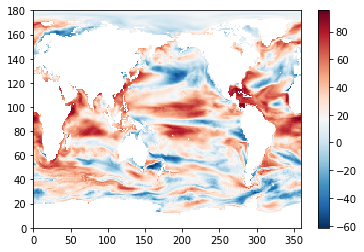

In [19]:
# regression of CO2 flux onto AMOC 26N
fgco2=df.fgco2.to_numpy()
D=np.reshape(fgco2,(165,180*360),order='C')
X=np.reshape(amoc26Na,(165,1))
Dp=D-np.mean(D,axis=0)
Xp=X-np.mean(X)
C=Dp.T@Xp
Vx=np.var(X)
Vd=np.reshape(np.var(Dp,axis=0),(180*360,1))
#
# regression coefficient
Regr=np.reshape(C/Vx,(180,360),order='C')
Corr=np.reshape(C/np.sqrt(Vd)/np.sqrt(Vx),(180,360),order='C')
plt.pcolormesh(Corr,cmap='RdBu_r')#,vmin=-0.002,vmax=0.002)
plt.colorbar()

## CESM2 analysis

In [21]:
dpr='/global/cfs/cdirs/m3920/dataset/cmip6/CESM2/'
ds=nc.Dataset(dpr+'/msftmz_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc')
df=xr.open_dataset(dpr+'/fgco2_CESM2_Omon_historical_r1i1p1f1_gn_woagrid.nc')
df2=xr.open_dataset(dpr+'/fgco2nat_CESM2_Omon_historical_r1i1p1f1_gn_woagrid.nc')

/global/homes/t/takaito/miniconda3/envs/analysis2/lib/python3.7/site-packages/numpy/core/_methods.py:163: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  arr = asanyarray(a)


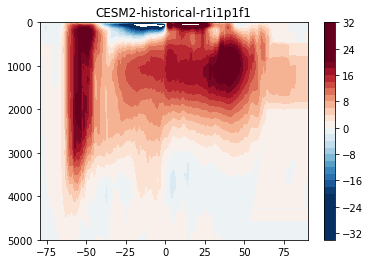

In [22]:
moc0=ds['msftmz']
moc1=np.mean(moc0,axis=0)*1e-6/1025#.mean(dim='time')
x=ds['lat'][:]#.to_numpy()
y=ds['lev'][:]*1e-2#.to_numpy()
time=np.arange(1850,2015,1/12)
moc=np.squeeze(moc1[2,:,:])
c=np.arange(-34,34,2)
plt.contourf(x,y,moc,c,cmap='RdBu_r',vmin=-20,vmax=20)
plt.ylim(5000,0)
plt.colorbar()
plt.title('CESM2-historical-r1i1p1f1')
wn='fig_amoc_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

In [23]:
idx = (np.abs(x - 26)).argmin()
moc3=np.squeeze(moc0[:,0,:,idx])*1e-6/1025

/global/homes/t/takaito/miniconda3/envs/analysis2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


/global/homes/t/takaito/miniconda3/envs/analysis2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


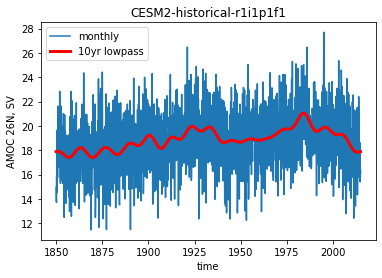

In [24]:
amoc26N=np.max(moc3,axis=1)

# fft filter
c=np.fft.fft(amoc26N)
freq=np.fft.fftfreq(np.size(amoc26N))
ind=(np.abs(freq)>1/120)
c[ind]=0
amoc_lp=np.fft.ifft(c)
plt.plot(time,amoc26N,label='monthly')
plt.plot(time,amoc_lp,'r-',label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.ylabel('AMOC 26N, SV')
plt.legend()
plt.title('CESM2-historical-r1i1p1f1')
wn='fig_amocts_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

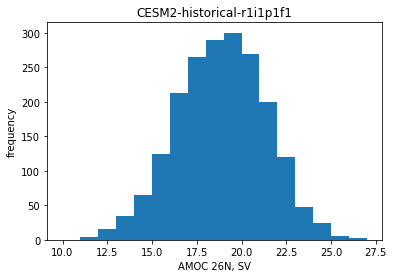

In [25]:
b=np.arange(10,28,1)
plt.hist(amoc26N,b)
plt.ylabel('frequency')
plt.xlabel('AMOC 26N, SV')
plt.title('CESM2-historical-r1i1p1f1')
plt.show()

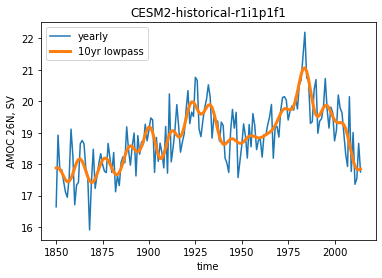

In [26]:
# annual mean
moc5=np.reshape(amoc26N,[165,12])
amoc26Na=np.mean(moc5,axis=1)
year=np.arange(1850,2015,1)
# fft filter
c=np.fft.fft(amoc26Na)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/10)
c[ind]=0
amoc_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,amoc26Na,label='yearly')
plt.plot(np.linspace(1850,2014,165),amoc_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.ylabel('AMOC 26N, SV')
plt.title('CESM2-historical-r1i1p1f1')
wn='fig_amocts_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()


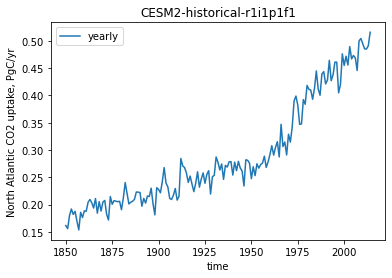

In [27]:
R=6.37e6
dx=1
cfac=365.25*86400*1.e3
# calculate global uptake
weights=np.cos(np.deg2rad(df.lat))*(R*np.pi/180*dx)**2
weights.name = "weights"
fgco2a=df.fgco2.groupby('time.year').mean(dim='time')
#fgco2=fgco2a.where((df.lon>=300)&(df.lat>10))
fgco2=fgco2a.where((df.lat>=10)&((df.lon>(360-85))|(df.lon<10)))
fgco2_weighted=fgco2.weighted(weights)
co2uptake=cfac*fgco2_weighted.sum(('lon','lat'))*1e-15
year=fgco2.year
#
# fft filter
y=co2uptake.to_numpy()
c=np.fft.fft(y)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/10)
c[ind]=0
co2uptake_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,co2uptake,label='yearly')
#plt.plot(year,co2uptake_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.title('CESM2-historical-r1i1p1f1')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
wn='fig_NAfgco2ts_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

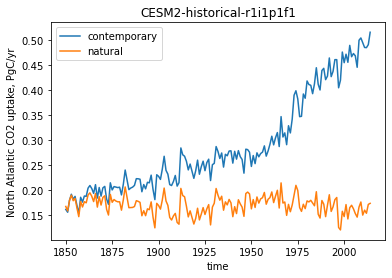

In [28]:
# replot with fgco2nat
R=6.37e6
dx=1
cfac=365.25*86400*1.e3
# calculate global uptake
weights=np.cos(np.deg2rad(df.lat))*(R*np.pi/180*dx)**2
weights.name = "weights"
fgco2a=df2.fgco2nat.groupby('time.year').mean(dim='time')
#fgco2=fgco2a.where((df.lon>=300)&(df.lat>10))
fgco2=fgco2a.where((df.lat>=10)&((df.lon>(360-85))|(df.lon<10)))
fgco2_weighted=fgco2.weighted(weights)
co2uptake2=cfac*fgco2_weighted.sum(('lon','lat'))*1e-15
year=fgco2.year
#
# fft filter
y=co2uptake2.to_numpy()
c=np.fft.fft(y)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/10)
c[ind]=0
co2uptake2_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,co2uptake,label='contemporary')
plt.plot(year,co2uptake2,label='natural')
#plt.plot(year,co2uptake_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.title('CESM2-historical-r1i1p1f1')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
wn='fig_NAfgco2ts_cesm2_2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

ratio(yearly)= 0.04348823527717766
ratio(low pass)= 0.06359903366389814


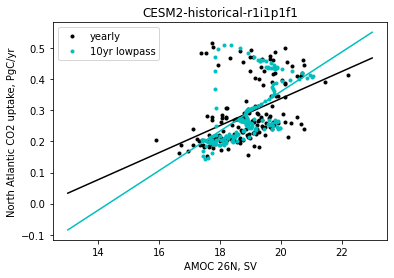

In [29]:
#x=amoc_lp
x=amoc26Na
#y=co2uptake_lp
y=co2uptake.to_numpy()
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
x0=np.linspace(13,23,20)
#
plt.plot(x,y,'k.',label='yearly')
plt.plot(x0,a*x0+b,'k-')
print('ratio(yearly)=',a)
#
x=amoc_lp
y=co2uptake_lp
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
plt.plot(amoc_lp,co2uptake_lp,'c.',label='10yr lowpass')
plt.plot(x0,a*x0+b,'c-')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
plt.legend()
plt.xlabel('AMOC 26N, SV')
plt.title('CESM2-historical-r1i1p1f1')
print('ratio(low pass)=',a)
wn='fig_amocco2_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

ratio(yearly)= -0.0010189908313189098
ratio(low pass)= -0.0003148841993852517


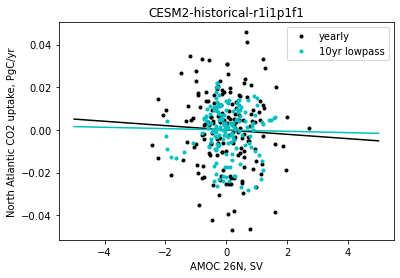

In [30]:
#x=amoc_lp
x=detrend(amoc26Na)
#y=co2uptake_lp
y=co2uptake2.to_numpy()
y=detrend(y)
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
x0=np.linspace(-5,5,20)
#
plt.plot(x,y,'k.',label='yearly')
plt.plot(x0,a*x0+b,'k-')
print('ratio(yearly)=',a)
#
x=detrend(amoc_lp)
y=detrend(co2uptake2_lp)
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
plt.plot(x,y,'c.',label='10yr lowpass')
plt.plot(x0,a*x0+b,'c-')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
plt.legend()
plt.xlabel('AMOC 26N, SV')
plt.title('CESM2-historical-r1i1p1f1')
print('ratio(low pass)=',a)
wn='fig_amocco2_cesm2_2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

# CanESM5

In [31]:
dpr='/global/cfs/cdirs/m3920/dataset/cmip6/CanESM5/'
ds=xr.open_dataset(dpr+'msftmz_Omon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')
df=xr.open_dataset(dpr+'/fgco2_CanESM5_Omon_historical_r1i1p1f1_gn_woagrid.nc')
df2=xr.open_dataset(dpr+'/fgco2nat_CanESM5_Omon_historical_r1i1p1f1_gn_woagrid.nc')

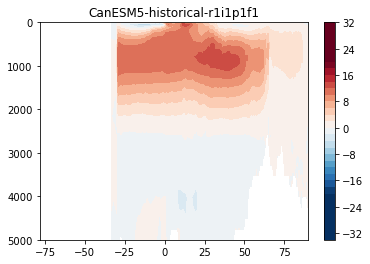

In [32]:
moc0=ds.msftmz
moc1=moc0.mean(dim='time').to_numpy()*1e-6/1025
x=ds.lat.to_numpy()
y=ds.lev.to_numpy()
moc=np.squeeze(moc1[0,:,:])
c=np.arange(-34,34,2)
plt.contourf(x,y,moc,c,cmap='RdBu_r',vmin=-20,vmax=20)
plt.ylim(5000,0)
plt.title('CanESM5-historical-r1i1p1f1')
plt.colorbar()
wn='fig_amoc_canesm5'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

In [33]:
moc2=moc0.sel(lat=26,method='nearest').to_numpy()*1e-6/1025
moc3=np.squeeze(moc2[:,0,:])
amoc26N=np.max(moc3,axis=1)

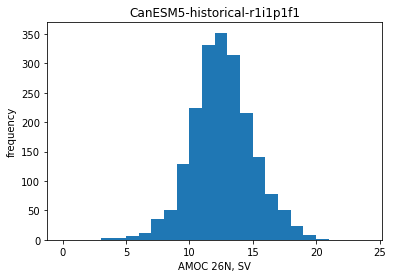

In [34]:
b=np.arange(0,25,1)
plt.hist(amoc26N,b)
plt.ylabel('frequency')
plt.xlabel('AMOC 26N, SV')
plt.title('CanESM5-historical-r1i1p1f1')
plt.show()

/global/homes/t/takaito/miniconda3/envs/analysis2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


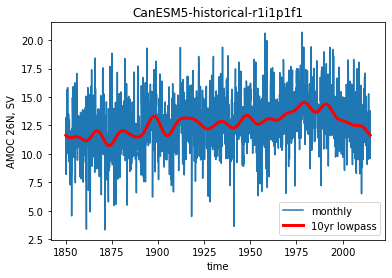

In [35]:
# fft filter
c=np.fft.fft(amoc26N)
freq=np.fft.fftfreq(np.size(amoc26N))
ind=(np.abs(freq)>1/120)
c[ind]=0
amoc_lp=np.fft.ifft(c)
plt.plot(time,amoc26N,label='monthly')
plt.plot(time,amoc_lp,'r-',label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.ylabel('AMOC 26N, SV')
plt.title('CanESM5-historical-r1i1p1f1')
plt.legend()
wn='fig_amocts_canesm5'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

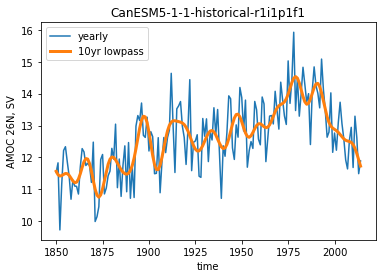

In [36]:
# annual mean
moc4=moc0.sel(lat=26,method='nearest')
moc5=moc4.groupby('time.year').mean(dim='time')
moc6=np.squeeze(moc5[:,0,:])
amoc26Na=np.max(moc6,axis=1).to_numpy()*1e-6/1025
year=moc5.year
# fft filter
c=np.fft.fft(amoc26Na)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/10)
c[ind]=0
amoc_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,amoc26Na,label='yearly')
plt.plot(np.linspace(1850,2014,165),amoc_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.ylabel('AMOC 26N, SV')
plt.title('CanESM5-1-1-historical-r1i1p1f1')
wn='fig_amocts_lowpass_canesm5'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()


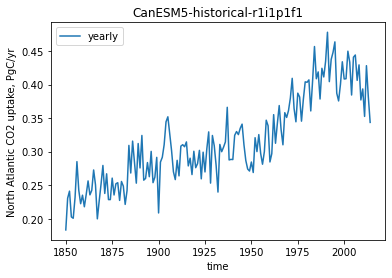

In [37]:
R=6.37e6
dx=1
cfac=365.25*86400*1.e3
# calculate global uptake
weights=np.cos(np.deg2rad(df.lat))*(R*np.pi/180*dx)**2
weights.name = "weights"
fgco2a=df.fgco2.groupby('time.year').mean(dim='time')
fgco2=fgco2a.where((df.lon>=300)&(df.lat>10))
fgco2_weighted=fgco2.weighted(weights)
co2uptake=cfac*fgco2_weighted.sum(('lon','lat'))*1e-15
year=fgco2a.year
#
# fft filter
y=co2uptake.to_numpy()
c=np.fft.fft(y)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/20)
c[ind]=0
co2uptake_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,co2uptake,label='yearly')
#plt.plot(year,co2uptake_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.title('CanESM5-historical-r1i1p1f1')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
wn='fig_NAfgco2ts_canesm5'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

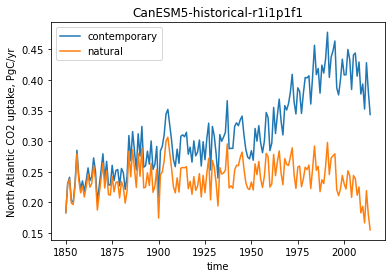

In [38]:
# recalculate with natural co2
R=6.37e6
dx=1
cfac=365.25*86400*1.e3
# calculate global uptake
weights=np.cos(np.deg2rad(df.lat))*(R*np.pi/180*dx)**2
weights.name = "weights"
fgco2a=df2.fgco2nat.groupby('time.year').mean(dim='time')
fgco2=fgco2a.where((df.lon>=300)&(df.lat>10))
fgco2_weighted=fgco2.weighted(weights)
co2uptake2=cfac*fgco2_weighted.sum(('lon','lat'))*1e-15
year=fgco2a.year
#
# fft filter
y=co2uptake2.to_numpy()
c=np.fft.fft(y)
freq=np.fft.fftfreq(np.size(amoc26Na))
ind=(np.abs(freq)>1/20)
c[ind]=0
co2uptake2_lp=np.real(np.fft.ifft(c))
#
plt.plot(year,co2uptake,label='contemporary')
plt.plot(year,co2uptake2,label='natural')
#plt.plot(year,co2uptake_lp,label='10yr lowpass',linewidth=3)
plt.xlabel('time')
plt.legend()
plt.title('CanESM5-historical-r1i1p1f1')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
wn='fig_NAfgco2ts_canesm5_2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

ratio(yearly)= 0.03343036716913829
ratio(low pass)= 0.04966592343782343


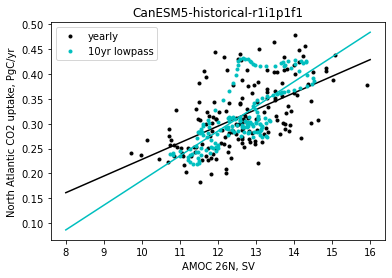

In [39]:
#x=amoc_lp
x=amoc26Na
#y=co2uptake_lp
y=co2uptake.to_numpy()
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
x0=np.linspace(8,16,20)
#
plt.plot(x,y,'k.',label='yearly')
plt.plot(x0,a*x0+b,'k-')
print('ratio(yearly)=',a)
#
x=np.real(amoc_lp)
y=np.real(co2uptake_lp)
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
plt.plot(amoc_lp,co2uptake_lp,'c.',label='10yr lowpass')
plt.plot(x0,a*x0+b,'c-')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
plt.legend()
plt.xlabel('AMOC 26N, SV')
plt.title('CanESM5-historical-r1i1p1f1')
print('ratio(low pass)=',a)
wn='fig_amocco2_canesm5'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()



ratio(yearly)= 0.0070217895081521155  : R2 =  0.08240431115926831
ratio(low pass)= 0.008926726869487048  : R2 =  0.2717243177245277


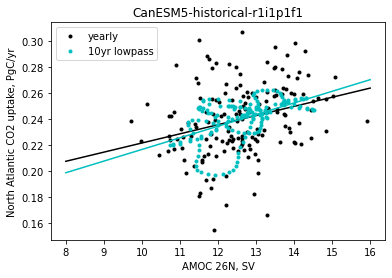

In [40]:
#x=amoc_lp
x=amoc26Na
#y=co2uptake_lp
y=co2uptake2.to_numpy()
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
r2=d[0,1]**2/d[0,0]/d[1,1]
x0=np.linspace(8,16,20)
#
plt.plot(x,y,'k.',label='yearly')
plt.plot(x0,a*x0+b,'k-')
print('ratio(yearly)=',a,' : R2 = ',r2)
#
x=np.real(amoc_lp)
y=np.real(co2uptake2_lp)
d=np.cov(x,y)
a=d[0,1]/d[0,0]
b=np.mean(y)-a*np.mean(x)
r2=d[0,1]**2/d[0,0]/d[1,1]
plt.plot(amoc_lp,co2uptake2_lp,'c.',label='10yr lowpass')
plt.plot(x0,a*x0+b,'c-')
plt.ylabel('North Atlantic CO2 uptake, PgC/yr')
plt.legend()
plt.xlabel('AMOC 26N, SV')
plt.title('CanESM5-historical-r1i1p1f1')
print('ratio(low pass)=',a,' : R2 = ',r2)
wn='fig_amocco2_canesm5_2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()